In [1]:
import pandas as pd
import matplotlib.pylab as plt
import requests
import numpy as np
import seaborn as sns

import missingno as msno
import datetime

import ee
# ee.Authenticate()
ee.Initialize()

## Download Streamflow data
San Lorenzo River, Santa Cruz County, California
USGS streamflow data is in *local* time... so loses an hour or missing an hour at each time zone. Change data to be in PST so it matches clock time in the winter when the most "action" is. 

In [2]:
def download_usgs_data(site, code1, code2, startDT, endDT):
    
    usgs_water_api = ("https://waterservices.usgs.gov/nwis/iv/?format=json&sites=" + site +  "&parameterCd=" + code1 + "," + code2 + 
                  "&siteStatus=all&startDT=" + startDT + "&endDT=" + endDT)
    api_response = requests.get(usgs_water_api)
    
    water_data = api_response.json()
    flow_data = pd.DataFrame(water_data['value']['timeSeries'][0]['values'][0]['value']).sort_values('dateTime')
    stage_data = pd.DataFrame(water_data['value']['timeSeries'][1]['values'][0]['value']).sort_values('dateTime')
    
    
    streamflow_raw = pd.merge(flow_data, stage_data, how='outer', on='dateTime')

    return streamflow_raw

In [3]:
#import streamflow data for San Lorenzo River at Big Trees
site = '11160500'
code1 = '00060'
code2 = '00065'
startDT = '1987-10-01T00:00:00.000-07:00'
endDT = '2024-06-18T00:00:00.000-07:00'

streamflow_BT_raw = download_usgs_data(site, code1, code2, startDT, endDT)
streamflow_BT_raw.head()


,value_x,qualifiers_x,dateTime,value_y,qualifiers_y
0,9.40,"[A, [91]]",1987-10-01T00:15:00.000-07:00,NaN,NaN
1,9.40,"[A, [91]]",1987-10-01T00:30:00.000-07:00,NaN,NaN
2,9.40,"[A, [91]]",1987-10-01T00:45:00.000-07:00,NaN,NaN
3,9.40,"[A, [91]]",1987-10-01T01:00:00.000-07:00,NaN,NaN
4,9.40,"[A, [91]]",1987-10-01T01:15:00.000-07:00,NaN,NaN


In [4]:
# import Santa Cruz streamflow data for San Lorenzo River
site = '11161000'
code1 = '00060'
code2 = '00065'
startDT = '1987-10-01T00:00:00.000-07:00'
endDT = '2024-06-18T00:00:00.000-07:00'

streamflow_SC_raw = download_usgs_data(site, code1, code2, startDT, endDT)
streamflow_SC_raw.head()


,value_x,qualifiers_x,dateTime,value_y,qualifiers_y
0,4.40,"[A, [91]]",1987-10-01T00:15:00.000-07:00,NaN,NaN
1,4.40,"[A, [91]]",1987-10-01T00:30:00.000-07:00,NaN,NaN
2,3.90,"[A, [91]]",1987-10-01T00:45:00.000-07:00,NaN,NaN
3,3.70,"[A, [91]]",1987-10-01T01:00:00.000-07:00,NaN,NaN
4,3.20,"[A, [91]]",1987-10-01T01:15:00.000-07:00,NaN,NaN


In [5]:
# combine streamflow data into one df

def process_streamflow(streamflow_data):
    #create datetime index
    streamflow_data.index = pd.to_datetime([x[0:-6] for x in streamflow_data['dateTime']]) 

    # convert data to PST (-08:00) 
    streamflow_data['tz'] = [x[-6::] for x in streamflow_data['dateTime']]
    streamflow_data.loc[streamflow_data.tz == '-07:00', :].index = streamflow_data.loc[streamflow_data.tz == '-07:00', :].index - pd.Timedelta(1, 'hour')

    #rename cols
    col_mapper = {'value_x': 'q_cfs', 'qualifiers_x': 'code_q', 'value_y': 'stage_ft', 'qualifiers_y': 'code_stage'}
    streamflow_data.rename(col_mapper, axis=1, inplace=True) # rename cols

    #cfs to numeric 
    streamflow_data[['stage_ft', 'q_cfs']] = streamflow_data[['stage_ft', 'q_cfs']].apply(pd.to_numeric)

    # resample to 15 min to account for timechange dupes
    streamflow_data_resample = streamflow_data.resample('15min').agg({'q_cfs': 'mean',
                                                                     'stage_ft': 'mean',
                                                                     'code_q': 'first', 
                                                                     'code_stage': 'first', 
                                                                     'dateTime': 'first', 
                                                                     'tz': 'first'})

    streamflow_data_resample.drop(['dateTime'], axis=1, inplace=True)
# comment out resample to daily, keep 15 min for modeling later
    # streamflow_data_resample = streamflow_data_resample.resample('1D').agg({'q_cfs': 'max',
    #                                                                      'stage_ft': 'max',
    #                                                                      'code_q': 'first', 
    #                                                                      'code_stage': 'first', 
    #                                                                          'tz': 'first'})

    streamflow_data_resample.rename({'q_cfs': 'q_cfs_peak'}, axis=1, inplace=True)
    
    return streamflow_data_resample

streamflow_BT = process_streamflow(streamflow_BT_raw)

streamflow_SC = process_streamflow(streamflow_SC_raw)

# merge all data
streamflow = pd.merge(streamflow_BT, streamflow_SC, how='outer', left_index=True, right_index=True, suffixes=['_BT', '_SC'])

streamflow.dropna().head()

,q_cfs_peak_BT,stage_ft_BT,code_q_BT,code_stage_BT,tz_BT,q_cfs_peak_SC,stage_ft_SC,code_q_SC,code_stage_SC,tz_SC
2007-10-01 01:00:00,11.7,3.04,[A],[A],-07:00,2.72,3.98,[A],[A],-07:00
2007-10-01 01:15:00,11.3,3.03,[A],[A],-07:00,2.47,3.97,[A],[A],-07:00
2007-10-01 01:30:00,11.3,3.03,[A],[A],-07:00,2.47,3.97,[A],[A],-07:00
2007-10-01 01:45:00,11.7,3.04,[A],[A],-07:00,2.72,3.98,[A],[A],-07:00
2007-10-01 02:00:00,11.3,3.03,[A],[A],-07:00,2.47,3.97,[A],[A],-07:00


## download precipitation data from Ben Lomond Station near Felton, CA within the San Lorenzo watershed. 
Data is event-based data, with timestamp saved for each tip of the rain tipping bucket. Code below recalculated to incremental data resampled to every 15 minutes. 

In [6]:
#download Ben Lomond precip data
cdec_bl_api = 'https://cdec.water.ca.gov/dynamicapp/req/JSONDataServlet?Stations=BLN&SensorNums=16&dur_code=E&Start=1997-12-10&End=2024-06-18'

response = requests.get(cdec_bl_api)
rain_data = response.json()


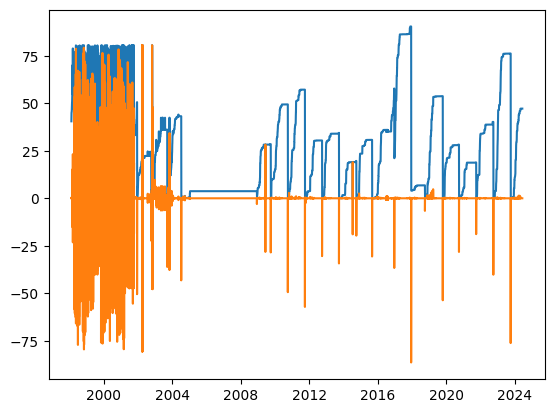

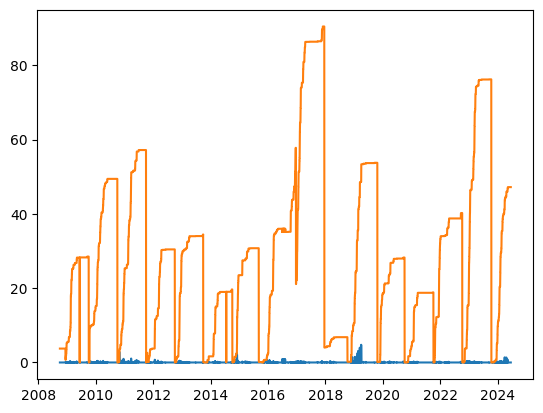

In [7]:
## clean event-based rain data (tip events to 15 minute data)
event_rain = pd.DataFrame(rain_data)
event_rain['dt'] = pd.to_datetime(event_rain['date'])
event_rain.index = event_rain['dt']
event_rain_resample = event_rain[['dt', 'value']].resample('15min').ffill()
event_rain_resample['inc'] = event_rain_resample['value'].diff()

plt.plot(event_rain_resample[['value', 'inc']])

event_rain_cleaned = event_rain_resample.loc[event_rain_resample.index > pd.to_datetime('2008-10-01'), :]
event_rain_cleaned.loc[event_rain_cleaned.inc < 0, 'inc'] = 0 #negative increments are when tip resets to zero
event_rain_cleaned.loc[event_rain_cleaned.inc >10, 'inc'] = 0 # greater than 10 are when cumulative precip jumps back up to cumulative after data drop

event_rain_cleaned = event_rain_cleaned.rename({'inc': 'precip_in_inc', 'value': 'precip_in_cum'}, axis=1).drop('dt', axis=1)
plt.show()
plt.plot(event_rain_cleaned[['precip_in_inc', 'precip_in_cum']])



In [8]:
#check for missing
event_rain_cleaned.isna().sum()
# event_rain_cleaned

precip_in_cum    0
precip_in_inc    0
dtype: int64

## Add NDWI Values
Downloaded from climateengine.org, median NDWI (Green/NIR) over the whole watershed. 
Watershed boundary from: https://purl.stanford.edu/cp847hc0870

In [9]:
ndwi = pd.read_csv('NDWI_GreenNIR_watershed.csv', parse_dates=True, index_col=0)
ndwi.columns = ['ndwi_watershed_green_nir']
ndwi.loc[pd.to_datetime('2008-10-01'), 'ndwi_watershed_green_nir'] = 0

# ndwi_resample = ndwi.resample('1D').ffill()
# ndwi_resample

ndwi

,ndwi_watershed_green_nir
2008-10-03,-0.3965
2008-10-11,-0.6703
2008-10-19,-0.7362
2008-10-27,-0.6433
2008-11-04,-0.6932
...,...
2024-05-24,-0.6964
2024-06-01,-0.7089
2024-06-09,-0.7155
2024-06-17,-0.7088


## Merge; Check for missing values
Data prior to water year 2008 is very messy, discard. 
Missing precip is filled with zero 
Missing streamflow is linearly interpolated. 

In [10]:
# combine all data into one df 

hydro_data1 = pd.merge(event_rain_cleaned, streamflow, how='outer', left_index=True, right_index=True)
hydro_data = pd.merge(hydro_data1, ndwi, how='outer', left_index=True, right_index=True)
hydro_data['ndwi_watershed_green_nir'] = hydro_data['ndwi_watershed_green_nir'].ffill()

hydro_data.head()

,precip_in_cum,precip_in_inc,q_cfs_peak_BT,stage_ft_BT,code_q_BT,code_stage_BT,tz_BT,q_cfs_peak_SC,stage_ft_SC,code_q_SC,code_stage_SC,tz_SC,ndwi_watershed_green_nir
1987-10-01 00:15:00,NaN,NaN,9.4,NaN,"[A, [91]]",None,-07:00,4.4,NaN,"[A, [91]]",None,-07:00,NaN
1987-10-01 00:30:00,NaN,NaN,9.4,NaN,"[A, [91]]",None,-07:00,4.4,NaN,"[A, [91]]",None,-07:00,NaN
1987-10-01 00:45:00,NaN,NaN,9.4,NaN,"[A, [91]]",None,-07:00,3.9,NaN,"[A, [91]]",None,-07:00,NaN
1987-10-01 01:00:00,NaN,NaN,9.4,NaN,"[A, [91]]",None,-07:00,3.7,NaN,"[A, [91]]",None,-07:00,NaN
1987-10-01 01:15:00,NaN,NaN,9.4,NaN,"[A, [91]]",None,-07:00,3.2,NaN,"[A, [91]]",None,-07:00,NaN


In [11]:
# check for missing
hydro_data.isna().sum()

precip_in_cum               736660
precip_in_inc               736660
q_cfs_peak_BT                 9899
stage_ft_BT                 702669
code_q_BT                     9899
code_stage_BT               702669
tz_BT                         9583
q_cfs_peak_SC                37465
stage_ft_SC                 707361
code_q_SC                    37465
code_stage_SC               707361
tz_SC                        36397
ndwi_watershed_green_nir    736415
dtype: int64

<Axes: >

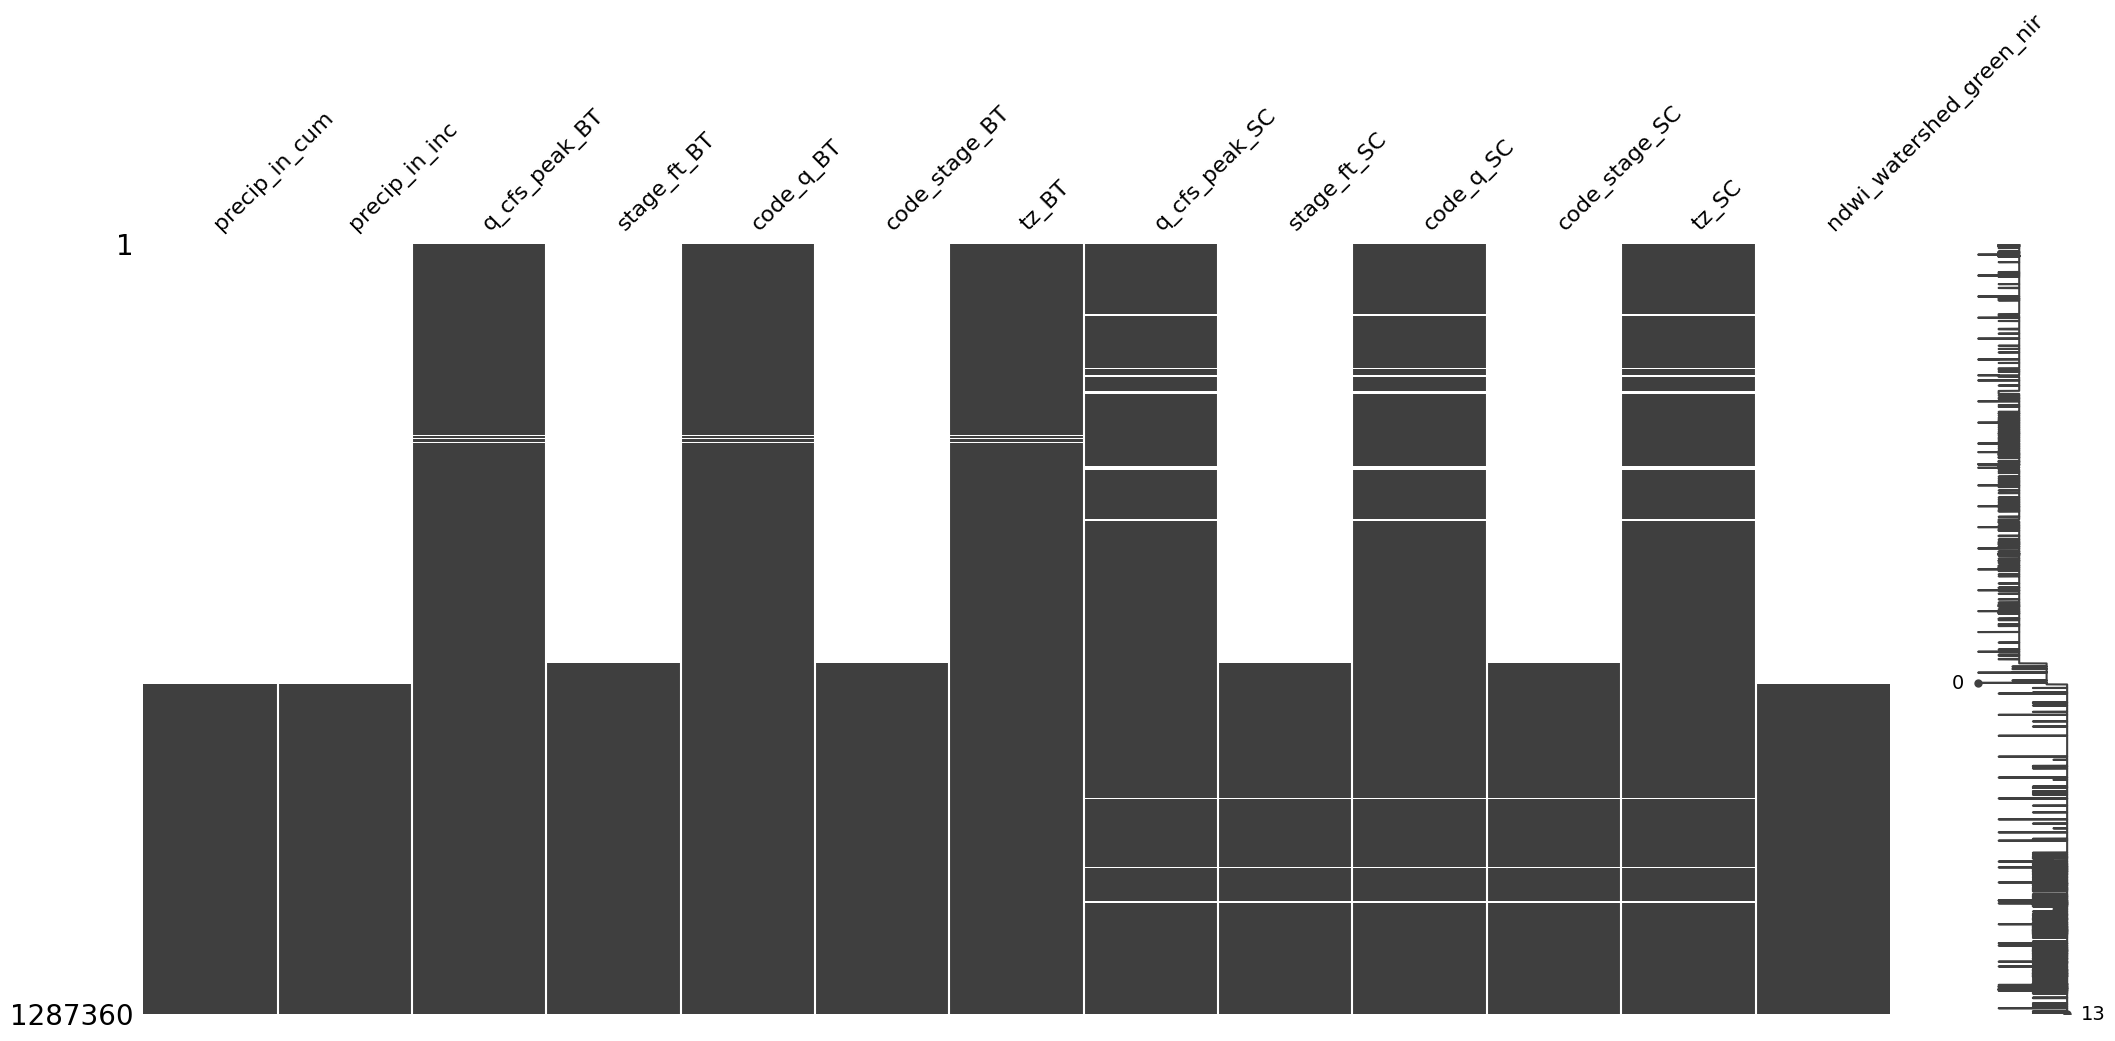

In [12]:
msno.matrix(hydro_data)

precip_in_cum                245
precip_in_inc                245
q_cfs_peak_BT               1274
stage_ft_BT                 1150
code_q_BT                   1274
code_stage_BT               1150
tz_BT                       1095
q_cfs_peak_SC               6777
stage_ft_SC                 6062
code_q_SC                   6777
code_stage_SC               6062
tz_SC                       5709
ndwi_watershed_green_nir       0
dtype: int64

<Axes: >

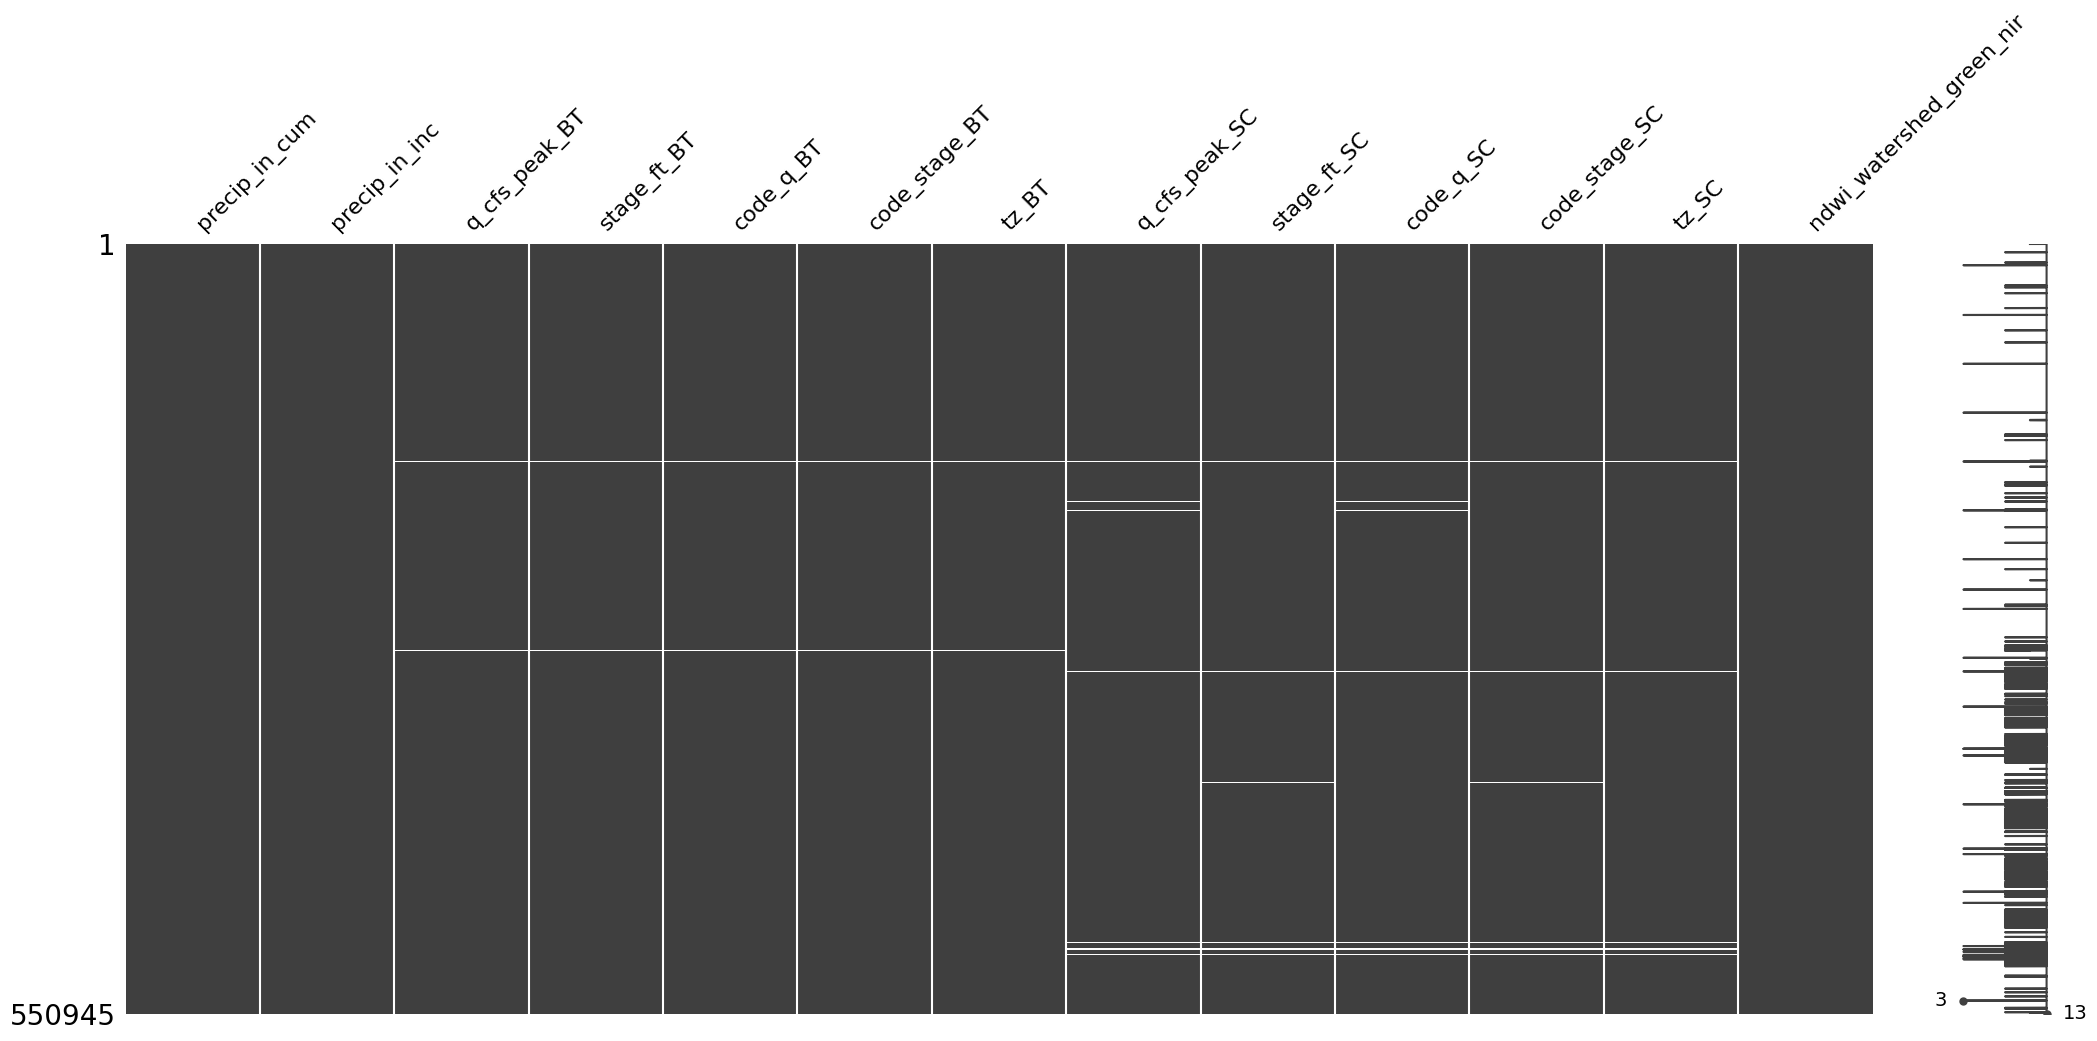

In [13]:
## keep only wy 2008 forward; check for missing in that time period (much less)
hydro_data = hydro_data.loc[(hydro_data.index >= pd.to_datetime('2008-10-01'))]
display(hydro_data.isna().sum())
msno.matrix(hydro_data)

In [14]:
### fill precip with zero, it's incremental rainfall, so zero is appropriate
hydro_data.precip_in_inc = hydro_data.precip_in_inc.fillna(0)
hydro_data.loc[hydro_data.index[0], 'precip_in_cum'] = 0 #fill first precip with 0
hydro_data.precip_in_cum = hydro_data.precip_in_cum.ffill()

display(hydro_data.isna().sum())


precip_in_cum                  0
precip_in_inc                  0
q_cfs_peak_BT               1274
stage_ft_BT                 1150
code_q_BT                   1274
code_stage_BT               1150
tz_BT                       1095
q_cfs_peak_SC               6777
stage_ft_SC                 6062
code_q_SC                   6777
code_stage_SC               6062
tz_SC                       5709
ndwi_watershed_green_nir       0
dtype: int64

precip_in_cum               float64
precip_in_inc               float64
q_cfs_peak_BT               float64
stage_ft_BT                 float64
code_q_BT                    object
code_stage_BT                object
tz_BT                        object
q_cfs_peak_SC               float64
stage_ft_SC                 float64
code_q_SC                    object
code_stage_SC                object
tz_SC                        object
ndwi_watershed_green_nir    float64
dtype: object

<Axes: >

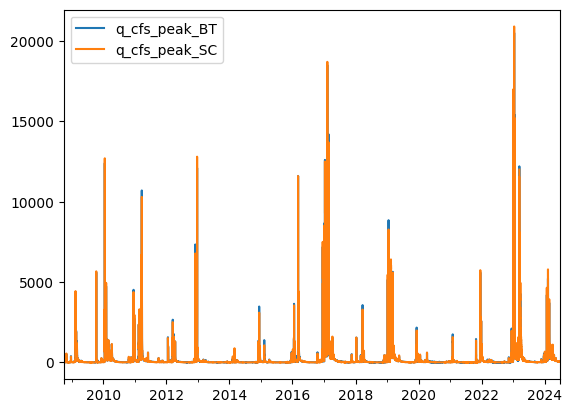

In [15]:
## code and datetime not important for modeling, so look at discharge
# hydro_data[['q_cfs_BT', 'q_cfs_SC']] = hydro_data[['q_cfs_BT', 'q_cfs_SC']].apply(pd.to_numeric)
display(hydro_data.dtypes)
hydro_data.plot(y=['q_cfs_peak_BT', 'q_cfs_peak_SC'])
# plt.yscale('log')

In [16]:
hydro_data.sort_values('q_cfs_peak_BT')

hydro_data.isna().sum()

precip_in_cum                  0
precip_in_inc                  0
q_cfs_peak_BT               1274
stage_ft_BT                 1150
code_q_BT                   1274
code_stage_BT               1150
tz_BT                       1095
q_cfs_peak_SC               6777
stage_ft_SC                 6062
code_q_SC                   6777
code_stage_SC               6062
tz_SC                       5709
ndwi_watershed_green_nir       0
dtype: int64

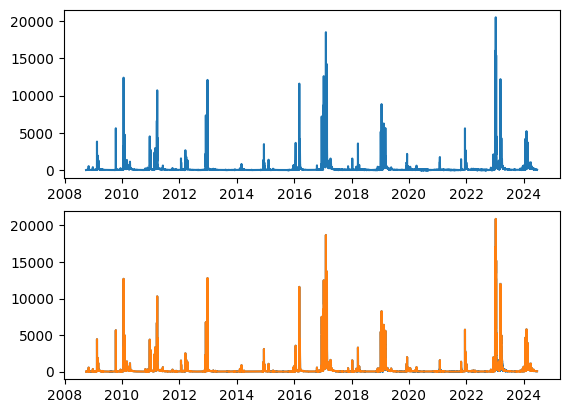

In [18]:
#interpolate data

#copy flow columns to keep old data to do a few comparisons
hydro_data[['q_cfs_peak_BT_int', 'q_cfs_peak_SC_int']] = hydro_data[['q_cfs_peak_BT', 'q_cfs_peak_SC']]
interpolate_col_list = ['q_cfs_peak_BT_int', 'q_cfs_peak_SC_int', 'stage_ft_BT', 'stage_ft_SC']
hydro_data[interpolate_col_list] = hydro_data[interpolate_col_list].interpolate()
f, ax = plt.subplots(2, 1)
ax[0].plot(hydro_data[['q_cfs_peak_BT']])
# ax[0].plot(hydro_data.q_cfs_BT.isna() * 10000 - 5000, linestyle='', marker='.')
ax[1].plot(hydro_data[['q_cfs_peak_SC', 'q_cfs_peak_SC_int']])
# ax[0].set_yscale('log')
# ax[0].set_xlim(pd.to_datetime('2018-04-01'), pd.to_datetime('2018-05-01'))

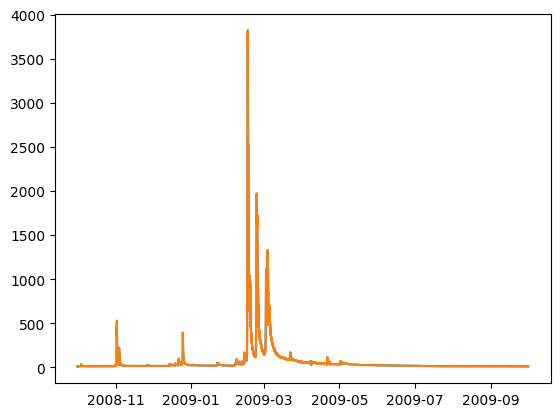

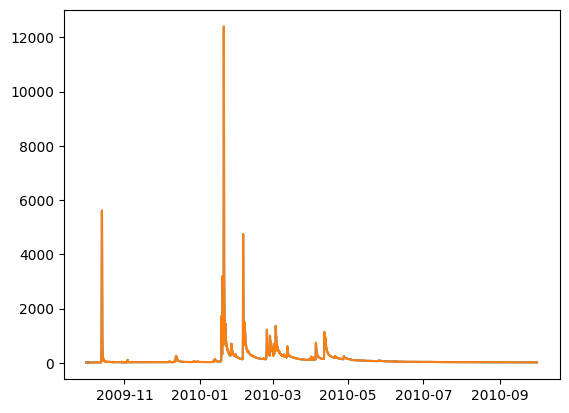

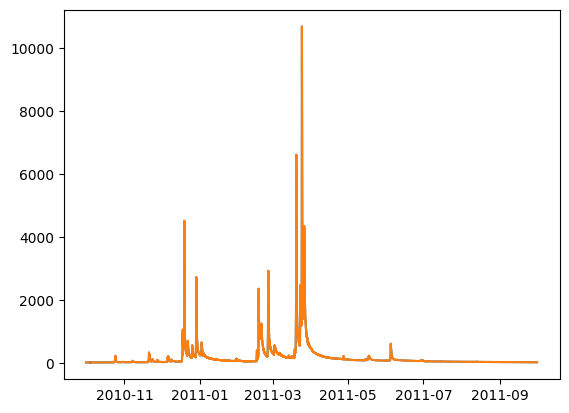

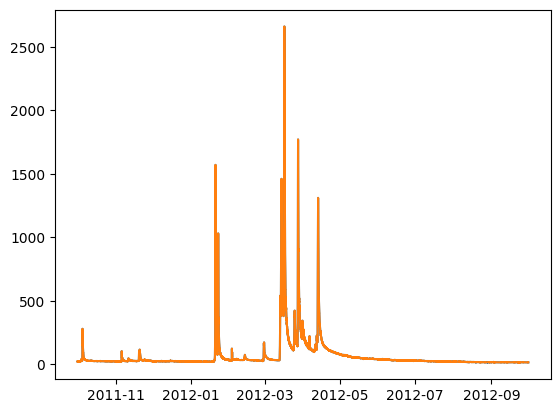

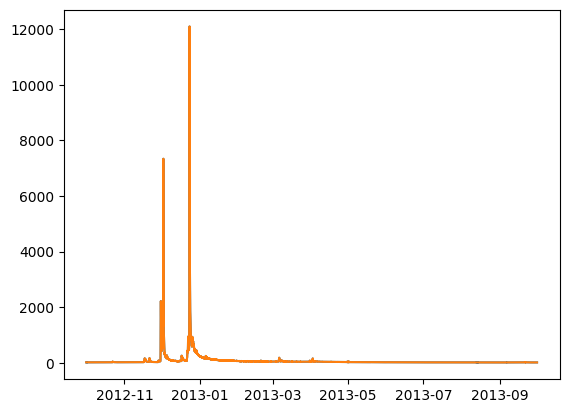

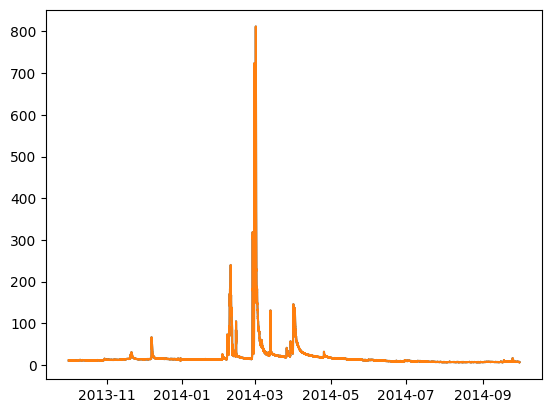

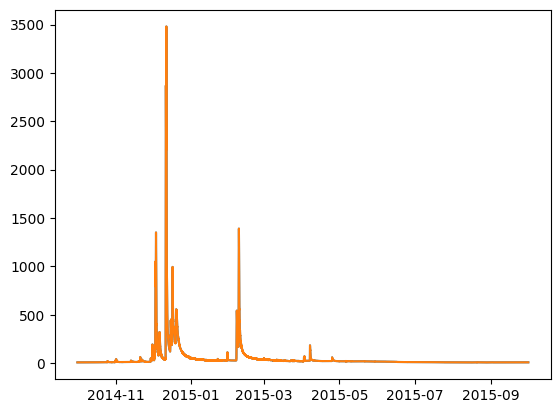

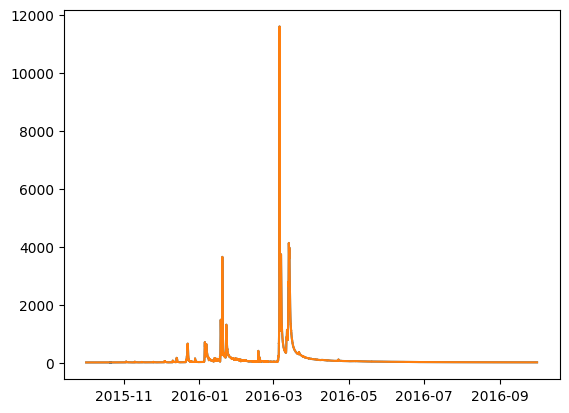

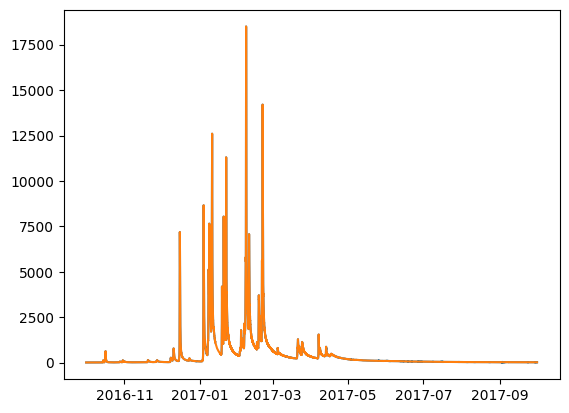

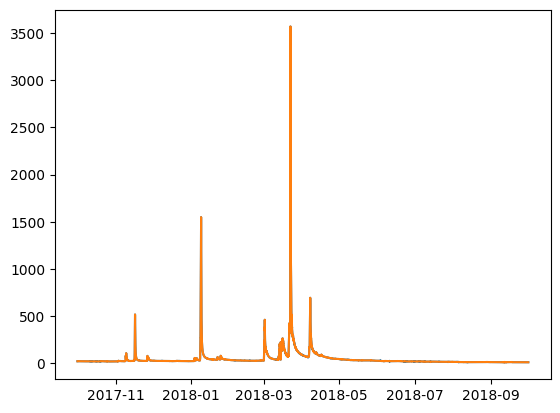

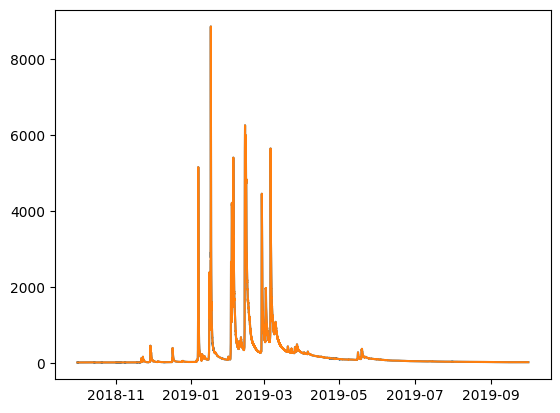

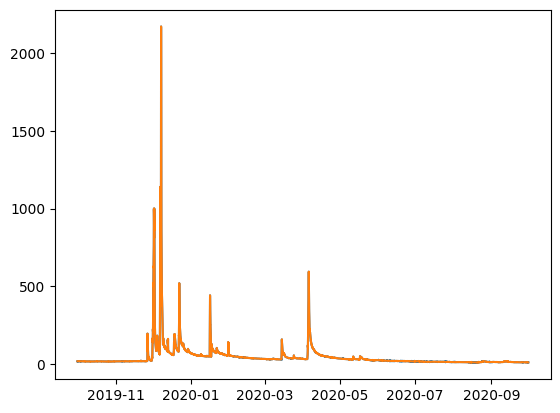

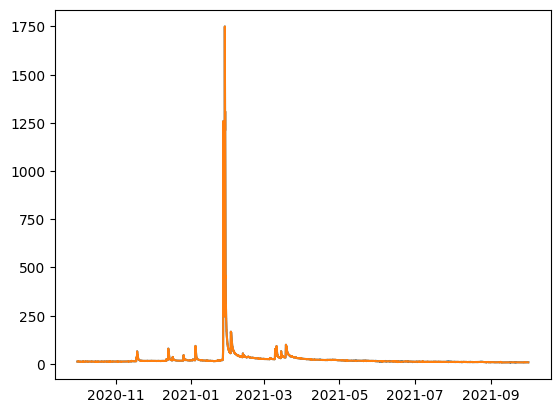

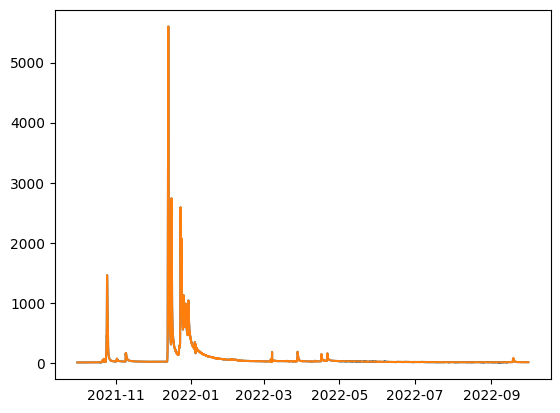

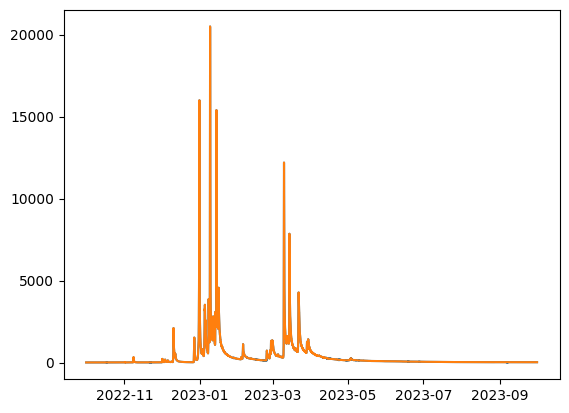

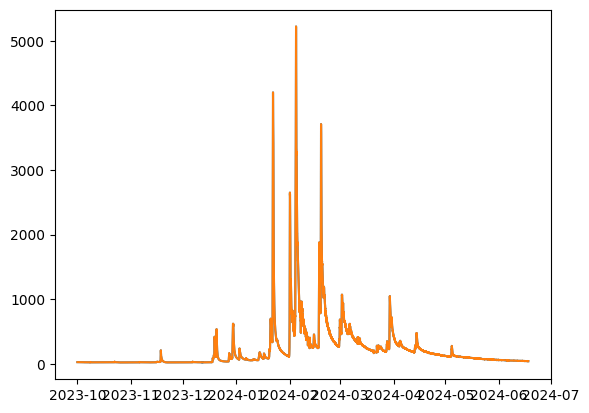

In [19]:
### plot each water year to visually check for interpolation problems

hydro_data['cy'] = hydro_data.index.year
hydro_data['month'] = hydro_data.index.month

hydro_data['wy'] = hydro_data.cy
hydro_data.loc[hydro_data['month'].isin([10, 11, 12]), 'wy'] = hydro_data.loc[hydro_data['month'].isin([10, 11, 12]), 'cy'] + 1

for wy in hydro_data['wy'].unique():
    f, ax = plt.subplots(1, 1)
    data_wy = hydro_data.loc[hydro_data['wy'] == wy, :]
    ax.plot(data_wy.index, data_wy[['q_cfs_peak_BT', 'q_cfs_peak_BT_int']])

In [20]:
#how many consecutive missing q values?
a = hydro_data[['q_cfs_peak_BT', 'q_cfs_peak_SC']].isna()
df1 = a.cumsum()-a.cumsum().where(~a).ffill().fillna(0).astype(int)
df1.max() / 96.0# days


q_cfs_peak_BT    1.000000
q_cfs_peak_SC    4.822917
dtype: float64

In [21]:
hydro_data.isna().sum()
hydro_data_clean = hydro_data.drop(['q_cfs_peak_BT', 'code_q_BT', 'code_stage_BT', 'q_cfs_peak_SC', 'code_q_SC', 
                                    'code_stage_SC', 'tz_BT', 'tz_SC'], axis=1)

hydro_data_clean


,precip_in_cum,precip_in_inc,stage_ft_BT,stage_ft_SC,ndwi_watershed_green_nir,q_cfs_peak_BT_int,q_cfs_peak_SC_int,cy,month,wy
2008-10-01 00:00:00,0.00,0.0,2.83,3.89,0.0000,10.8,1.43,2008,10,2009
2008-10-01 00:15:00,3.74,0.0,2.83,3.88,0.0000,10.8,1.26,2008,10,2009
2008-10-01 00:30:00,3.74,0.0,2.83,3.88,0.0000,10.8,1.26,2008,10,2009
2008-10-01 00:45:00,3.74,0.0,2.83,3.88,0.0000,10.8,1.26,2008,10,2009
2008-10-01 01:00:00,3.74,0.0,2.83,3.88,0.0000,10.8,1.26,2008,10,2009
...,...,...,...,...,...,...,...,...,...,...
2024-06-17 23:00:00,47.19,0.0,3.79,2.64,-0.7088,44.0,52.90,2024,6,2024
2024-06-17 23:15:00,47.19,0.0,3.79,2.65,-0.7088,44.0,53.70,2024,6,2024
2024-06-17 23:30:00,47.19,0.0,3.79,2.63,-0.7088,44.0,52.10,2024,6,2024
2024-06-17 23:45:00,47.19,0.0,3.78,2.65,-0.7088,43.3,53.70,2024,6,2024


In [22]:
## calculate flood stage category column for each gage. Source next to each var

flood_stage_bins_BT = np.array([0, 14, 16.5, 19.5, 21.76, 999]) # https://water.noaa.gov/gauges/btec1
hydro_data_clean['flood_stage_BT'] = pd.cut(hydro_data_clean['stage_ft_BT'], flood_stage_bins_BT, labels=False)

flood_stage_bins_SC = np.array([0, 18, 20.55, 23.33, 25.0, 999]) # https://water.noaa.gov/gauges/lrrc1
hydro_data_clean['flood_stage_SC'] = pd.cut(hydro_data_clean['stage_ft_SC'], flood_stage_bins_SC, labels=False)
hydro_data_clean.value_counts('flood_stage_SC')
hydro_data_clean.max()

precip_in_cum                  90.42
precip_in_inc                   4.76
stage_ft_BT                    24.54
stage_ft_SC                    23.94
ndwi_watershed_green_nir        0.00
q_cfs_peak_BT_int           20500.00
q_cfs_peak_SC_int           20900.00
cy                           2024.00
month                          12.00
wy                           2024.00
flood_stage_BT                  4.00
flood_stage_SC                  3.00
dtype: float64

## Check for outliers
Weird binning makes date features look uneven, but they aren't. Verified below. 

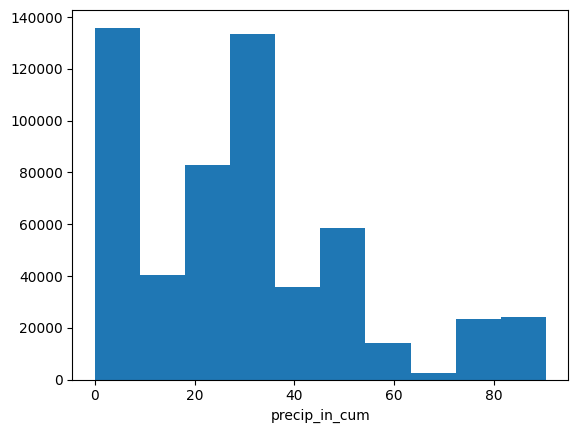

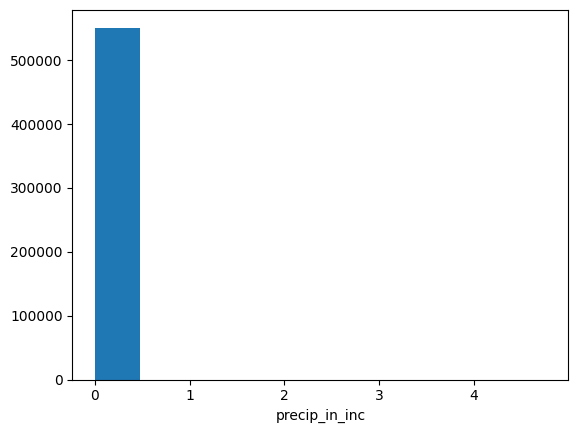

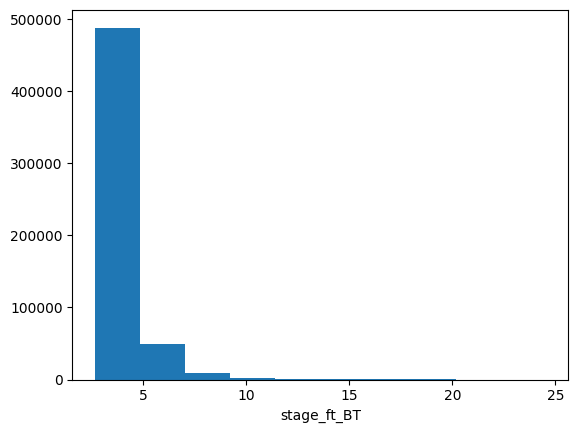

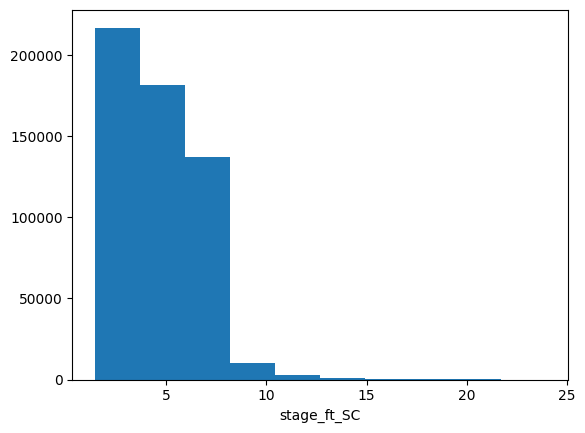

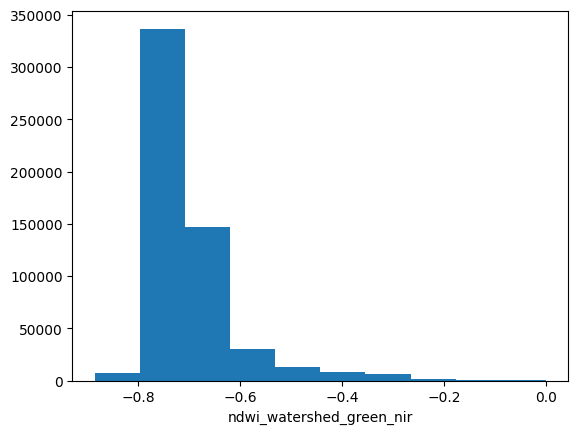

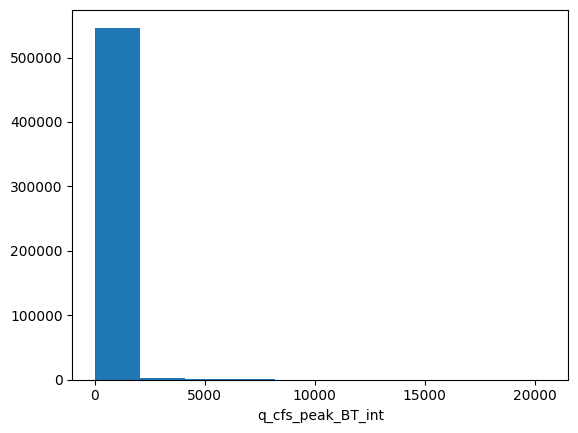

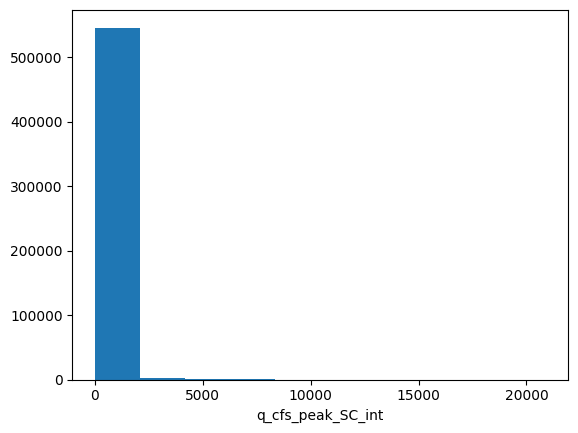

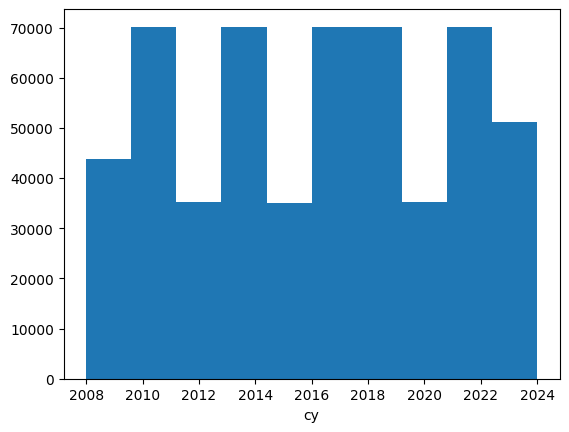

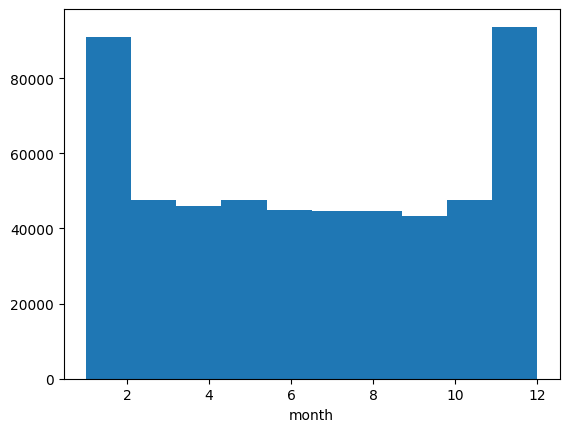

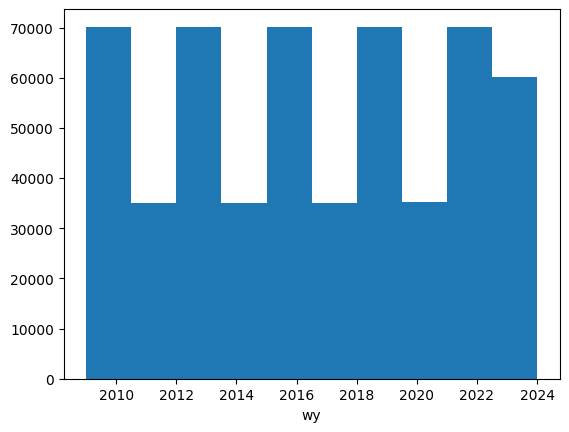

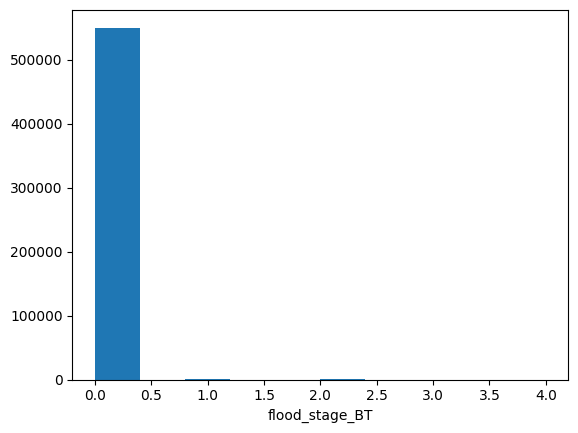

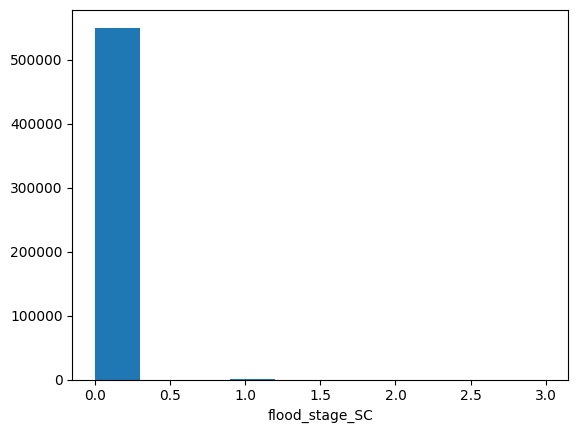

In [23]:
##outliers

for n in hydro_data_clean.columns:
    f, ax = plt.subplots(1, 1)
    ax.hist(hydro_data_clean[n])
    ax.set_xlabel(n)

# hydro_data_clean.head(20)

In [24]:
print('timestamp duplicates: ', hydro_data_clean.index.duplicated().sum())
display(hydro_data_clean.wy.value_counts())
display(hydro_data_clean.month.value_counts())

## no timestamp duplicates. Weird spikey histograms are binning issues. 

timestamp duplicates:  0


wy
2012    35136
2016    35136
2020    35136
2009    35040
2010    35040
2011    35040
2013    35040
2014    35040
2015    35040
2017    35040
2018    35040
2019    35040
2021    35040
2022    35040
2023    35040
2024    25057
Name: count, dtype: int64

month
10    47616
12    47616
1     47616
3     47616
5     47616
11    46080
4     46080
6     44833
7     44640
8     44640
2     43392
9     43200
Name: count, dtype: int64

## Add relevant wildfires and estimate percent of watershed burned. 

In [25]:
## wildfires
wildfire_percent = {2017: 341.136 / 88320.0, # https://data-nifc.opendata.arcgis.com/datasets/nifc::historic-perimeters-combined-2000-2018-geomac/about
                   2020: 0.2} # https://www.cityofsantacruz.com/government/city-departments/water/water-quality/czu-fire-water-quality

# wildfire_percent = pd.DataFrame(wildfire_percent, index=[0, 1])
wildfire_percent

{2017: 0.0038625000000000005, 2020: 0.2}

## Download drought index data 
from https://www.drought.gov/historical-information?dataset=0&selectedDateUSDM=20240618
for Santa Cruz County

In [26]:
#drought data, SC county

drought_data = pd.read_csv('USDM-06087.csv', parse_dates=['ValidStart', 'ValidEnd'])
drought_data.rename({'ValidStart': 'week_start'}, axis=1, inplace=True)
drought_data.index = drought_data.week_start
drought_data = drought_data[['D0', 'D1', 'D2', 'D3', 'D4']].copy()
drought_data = drought_data.sort_index()
drought_data#.loc[pd.to_datetime('2008-10-01'), :]

,D0,D1,D2,D3,D4
week_start,,,,,
2000-01-04,0.0,0.0,0.0,0.0,0.0
2000-01-11,0.0,0.0,0.0,0.0,0.0
2000-01-18,0.0,0.0,0.0,0.0,0.0
2000-01-25,0.0,0.0,0.0,0.0,0.0
2000-02-01,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2024-05-21,0.0,0.0,0.0,0.0,0.0
2024-05-28,0.0,0.0,0.0,0.0,0.0
2024-06-04,0.0,0.0,0.0,0.0,0.0


In [27]:
#merge drought and wildfire data
drought_data_resample = drought_data.resample('15min').ffill()
data = pd.merge(hydro_data_clean, drought_data_resample, left_index=True, right_index=True, how='left')
data = pd.merge(hydro_data_clean, drought_data_resample, left_index=True, right_index=True, how='left')

for k in wildfire_percent.keys():
    data.loc[data['wy'] == k, 'wildfire_percent'] = wildfire_percent[k]

data[['wildfire_percent']] = data[['wildfire_percent']].fillna(0)
data.head()


,precip_in_cum,precip_in_inc,stage_ft_BT,stage_ft_SC,ndwi_watershed_green_nir,q_cfs_peak_BT_int,q_cfs_peak_SC_int,cy,month,wy,flood_stage_BT,flood_stage_SC,D0,D1,D2,D3,D4,wildfire_percent
2008-10-01 00:00:00,0.00,0.0,2.83,3.89,0.0,10.8,1.43,2008,10,2009,0,0,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-01 00:15:00,3.74,0.0,2.83,3.88,0.0,10.8,1.26,2008,10,2009,0,0,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-01 00:30:00,3.74,0.0,2.83,3.88,0.0,10.8,1.26,2008,10,2009,0,0,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-01 00:45:00,3.74,0.0,2.83,3.88,0.0,10.8,1.26,2008,10,2009,0,0,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-01 01:00:00,3.74,0.0,2.83,3.88,0.0,10.8,1.26,2008,10,2009,0,0,100.0,100.0,0.0,0.0,0.0,0.0


In [28]:
data.loc[data['ndwi_watershed_green_nir'].isna(), 'ndwi_watershed_green_nir']

Series([], Freq: 15min, Name: ndwi_watershed_green_nir, dtype: float64)

In [29]:
#final nan/duplicate checks

display(data.isna().sum())
print('duplicates: ', data.index.duplicated().sum())

precip_in_cum               0
precip_in_inc               0
stage_ft_BT                 0
stage_ft_SC                 0
ndwi_watershed_green_nir    0
q_cfs_peak_BT_int           0
q_cfs_peak_SC_int           0
cy                          0
month                       0
wy                          0
flood_stage_BT              0
flood_stage_SC              0
D0                          0
D1                          0
D2                          0
D3                          0
D4                          0
wildfire_percent            0
dtype: int64

duplicates:  0


## Check variable correlations
Will likely use LSTM so checking lagged correlation as well

<Axes: >

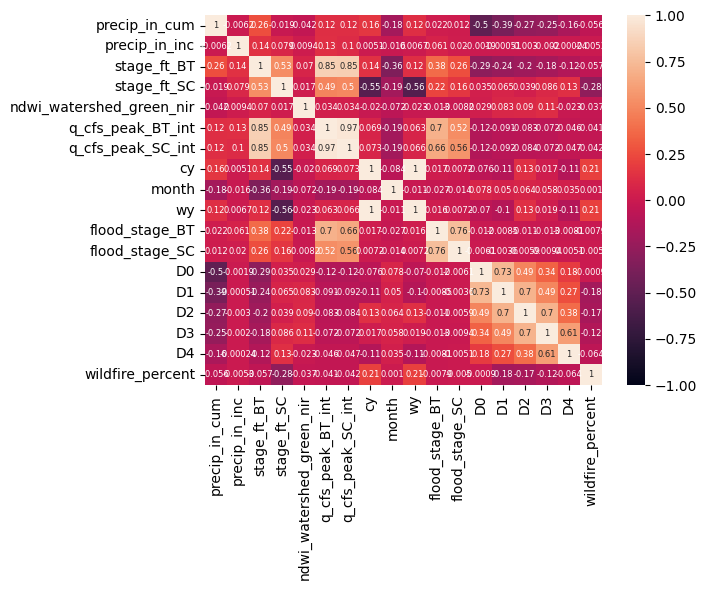

In [30]:
# plot correlation heatmap
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, annot_kws={"size":6}) 

In [31]:
## calculate correlations
data_daily = data.resample('1D').agg({'precip_in_inc': 'sum', 
                                     'precip_in_cum': 'median', 
                                     'stage_ft_BT': 'median', 
                                     'stage_ft_SC': 'median', 
                                     'q_cfs_peak_SC_int': 'median', 
                                     'q_cfs_peak_BT_int': 'median', 
                                     'ndwi_watershed_green_nir': 'median', 
                                     'D0': 'median', 'D1': 'median', 'D2': 'median', 'D3': 'median', 'D4': 'median', 
                                     })
data_daily

,precip_in_inc,precip_in_cum,stage_ft_BT,stage_ft_SC,q_cfs_peak_SC_int,q_cfs_peak_BT_int,ndwi_watershed_green_nir,D0,D1,D2,D3,D4
2008-10-01,0.0,3.74,2.83,3.850,1.11,11.3,0.0000,100.0,100.0,0.0,0.0,0.0
2008-10-02,0.0,3.74,2.83,3.880,1.26,11.3,0.0000,100.0,100.0,0.0,0.0,0.0
2008-10-03,0.0,3.74,2.84,3.870,1.26,11.6,-0.3965,100.0,100.0,0.0,0.0,0.0
2008-10-04,0.0,3.74,3.02,4.715,14.20,18.2,-0.3965,100.0,100.0,0.0,0.0,0.0
2008-10-05,0.0,3.74,2.96,4.900,20.50,15.8,-0.3965,100.0,100.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,0.0,47.19,3.84,2.710,58.50,47.6,-0.7155,0.0,0.0,0.0,0.0,0.0
2024-06-15,0.0,47.19,3.82,2.670,55.30,46.2,-0.7155,0.0,0.0,0.0,0.0,0.0
2024-06-16,0.0,47.19,3.81,2.670,55.30,45.4,-0.7155,0.0,0.0,0.0,0.0,0.0
2024-06-17,0.0,47.19,3.80,2.660,54.50,44.7,-0.7088,0.0,0.0,0.0,0.0,0.0


,lag,correlation
0,0,0.472379
1,1,0.402682
15,15,0.362173
29,29,0.34352
43,43,0.345084
57,57,0.348255
71,71,0.354691
85,85,0.380733
99,99,0.378207
113,113,0.375905


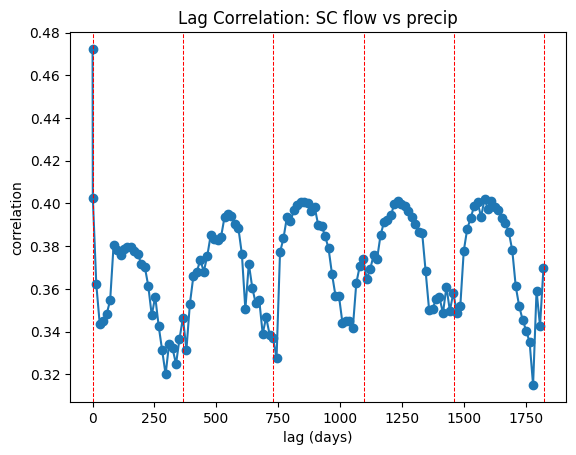

In [32]:
# calc lag correlation w precip, plot
lag_step = np.arange(1, 365*5, 14)
lag_step
lags_out = pd.DataFrame(columns=['lag', 'correlation'])
lags_out.loc[0, :] = [0, np.corrcoef(data_daily['q_cfs_peak_SC_int'], data_daily['precip_in_inc'])[1,0]]
for lag in lag_step:
    data_lag = data_daily.copy()
    data_lag['q_cfs_peak_BT_int'] = data_lag['q_cfs_peak_BT_int'].diff(lag)
    data_lag.dropna(inplace=True)
    lags_out.loc[lag, :] = [lag, np.corrcoef(data_lag['q_cfs_peak_BT_int'], data_lag['precip_in_inc'])[1,0]]
    
f, ax = plt.subplots(1, 1)
ax.plot(lags_out['lag'], lags_out['correlation'],  linestyle='-', marker='o')
ax.set_ylabel('correlation')
ax.set_xlabel('lag (days)')
ax.set_title('Lag Correlation: SC flow vs precip')
for x in np.arange(0, 6*365, 365):
    ax.axvline(x, c='r', linestyle='--', linewidth=0.75)
lags_out.head(20)

,lag,correlation
0,0,0.044092
1,1,0.001203
15,15,0.020633
29,29,0.005738
43,43,-0.000057
57,57,0.016365
71,71,0.028812
85,85,0.043226
99,99,0.048135
113,113,0.049371


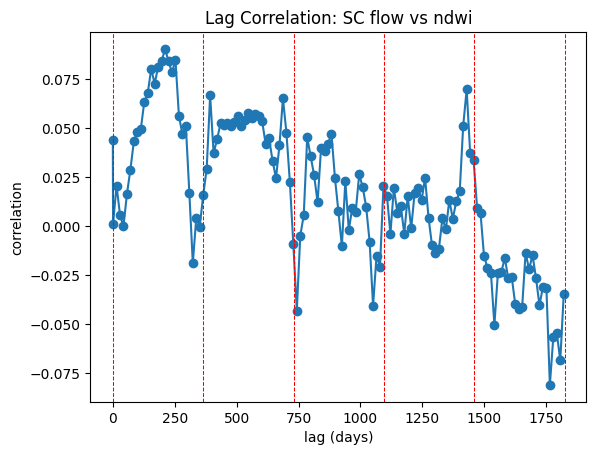

In [33]:
# calc lag correlation with ndwi, plot
lag_step = np.arange(1, 365*5, 14)
lag_step
lags_out = pd.DataFrame(columns=['lag', 'correlation'])
lags_out.loc[0, :] = [0, np.corrcoef(data_daily['q_cfs_peak_SC_int'], data_daily['ndwi_watershed_green_nir'])[1,0]]
for lag in lag_step:
    data_lag = data_daily.copy()
    data_lag['q_cfs_peak_BT_int'] = data_lag['q_cfs_peak_BT_int'].diff(lag)
    data_lag.dropna(inplace=True)
    lags_out.loc[lag, :] = [lag, np.corrcoef(data_lag['q_cfs_peak_BT_int'], data_lag['ndwi_watershed_green_nir'])[1,0]]
    
f, ax = plt.subplots(1, 1)
ax.plot(lags_out['lag'], lags_out['correlation'],  linestyle='-', marker='o')
ax.set_ylabel('correlation')
ax.set_xlabel('lag (days)')
ax.set_title('Lag Correlation: SC flow vs ndwi')
for x in np.arange(0, 6*365, 365):
    ax.axvline(x, c='r', linestyle='--', linewidth=0.75)
lags_out.head(20)

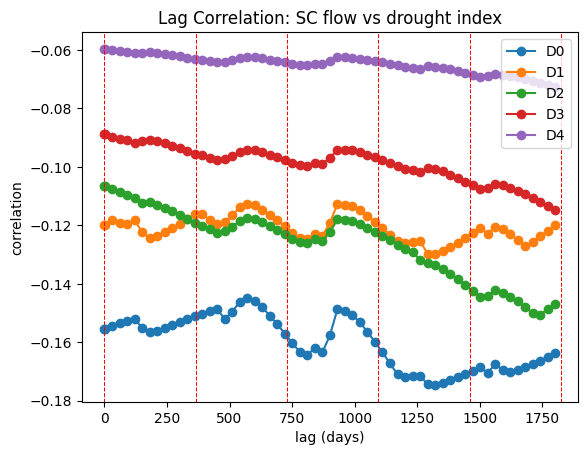

In [34]:
#lag correlation with each Drought category
lag_step = np.arange(1, 365*5, 30)
d_cat_list = ['D0', 'D1', 'D2', 'D3', 'D4']
lags_out = pd.DataFrame(columns=d_cat_list)

for d in d_cat_list:
    lags_out.loc[0, d] = np.corrcoef(data_daily['q_cfs_peak_SC_int'], data_daily[d])[1,0]
    
for lag in lag_step:
    data_lag = data_daily.copy()
    data_lag['q_cfs_peak_BT_int'] = data_lag['q_cfs_peak_BT_int'].diff(lag)
    data_lag.dropna(inplace=True)
    
    for d in d_cat_list:
        lags_out.loc[lag, d] = np.corrcoef(data_lag['q_cfs_peak_SC_int'], data_lag[d])[1,0]

    
f, ax = plt.subplots(1, 1)
ax.plot(lags_out.index, lags_out,  linestyle='-', marker='o')
ax.set_ylabel('correlation')
ax.set_xlabel('lag (days)')
ax.legend(lags_out.columns)
ax.set_title('Lag Correlation: SC flow vs drought index')

for x in np.arange(0, 6*365, 365):
    ax.axvline(x, c='r', linestyle='--', linewidth=0.75)

In [35]:
#save data
data.to_csv('01_data.csv')


## Summary
Data resampled to daily - laptop kernel was crashing with 15 min data when running model

No missing data or outliers. 
Lag correlations suggest that precipitation and streamflow correlation peaks about 4 months prior, so will need to look back at least 4 months for LSTM models. 
Drought index vs streamflow shows similar results; with small bumps in correlation around 4 months prior. 

Other potential data to add if model doesn't perform well: precipitation or humidity. Soil moisture metric? Maybe watershed scale NDWI? 